In [1]:
import sys
sys.path.append('/home/hashmi/ResearchBook/Tracking/Notebooks/Moore')
from central_import import *

figure_directory = '../../../Figures/FinalModel/'
os.makedirs(figure_directory,exist_ok=True)
set_plot_style()

In [2]:
#Calling the input file and shuffling the dataset
data = pd.read_parquet('../DataBuild/SciFiTrackTrainingData.parquet').sample(frac=1,random_state=51)

In [3]:
x=data.drop(['isMatched'],axis=1)
y=data['isMatched']

columns=np.array(['SciFiHits','Tx','Ty','X', 'Y','Eta','Phi','Chi2PerDoF'])
x.columns=columns

#Training Data
print(f"Dimension of the Data is : ",x.shape)
display(x.head())


Dimension of the Data is :  (4245176, 8)


,SciFiHits,Tx,Ty,X,Y,Eta,Phi,Chi2PerDoF
2384626,12,0.142903,-0.020017,272.910828,-161.444855,2.634187,-0.139168,0.221750
2418958,11,-0.582433,-0.080280,-1073.039795,-887.139099,1.301254,-3.004620,1.204288
170535,11,0.187015,-0.047983,722.949219,-388.110077,2.347029,-0.251154,0.193320
3663614,12,-0.120697,0.013600,445.310272,112.444862,2.804976,3.029385,0.173557
2242639,12,-0.477395,-0.099382,-754.030701,-148.278748,1.466098,-2.936348,0.124681


In [4]:
data.isMatched.value_counts(normalize=True)

isMatched
True     0.959904
False    0.040096
Name: proportion, dtype: float64

In [5]:
#Train-Test-Evaluation Split
x_train,x_temp,y_train,y_temp=train_test_split(x,y,stratify=y,random_state=35)
x_test,x_eval,y_test,y_eval=train_test_split(x_temp,y_temp,stratify=y_temp,random_state=35)

#Preprocessing of Train-Test Data
x_train=pd.DataFrame(scaler.fit_transform(x_train),columns=x.columns)
x_test=pd.DataFrame(scaler.transform(x_test),columns=x.columns)
x_eval=pd.DataFrame(scaler.transform(x_eval),columns=x.columns)

x_train,y_train=sampler.fit_resample(x_train,y_train)
# x_eval,y_eval=sampler.fit_resample(x_eval,y_eval)

#Catboost Pool Functionality
train_data=Pool(data=x_train,label=y_train)
test_data=Pool(data=x_test,label=y_test)
eval_data=Pool(data=x_eval,label=y_eval)

In [6]:
#Catboost Parameters for Training after Hyper-parameter Tuning.
catboost_params = {
    'eval_metric': 'AUC',
    'thread_count': 10,
    'learning_rate': 0.1,
    'iterations': 500,
    'depth': 6,
    'l2_leaf_reg': 3,
    'min_data_in_leaf': 10,
    'subsample': 0.8,
    'random_strength': 1,
    'border_count': 128,
    'early_stopping_rounds': 50
    }


#Model Training
model = CatBoostClassifier(**catboost_params)
model.fit(train_data,eval_set=eval_data,verbose=100,plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.9591224	best: 0.9591224 (0)	total: 96.7ms	remaining: 48.3s
100:	test: 0.9765812	best: 0.9765812 (100)	total: 6.17s	remaining: 24.4s
200:	test: 0.9780091	best: 0.9780148 (198)	total: 12s	remaining: 17.9s
300:	test: 0.9786008	best: 0.9786008 (300)	total: 17.7s	remaining: 11.7s
400:	test: 0.9789516	best: 0.9789558 (394)	total: 23.9s	remaining: 5.9s
499:	test: 0.9791990	best: 0.9791990 (499)	total: 30s	remaining: 0us

bestTest = 0.9791989677
bestIteration = 499



ROC-AUC Score :  94.06 %
F1 Score :  97.3 %


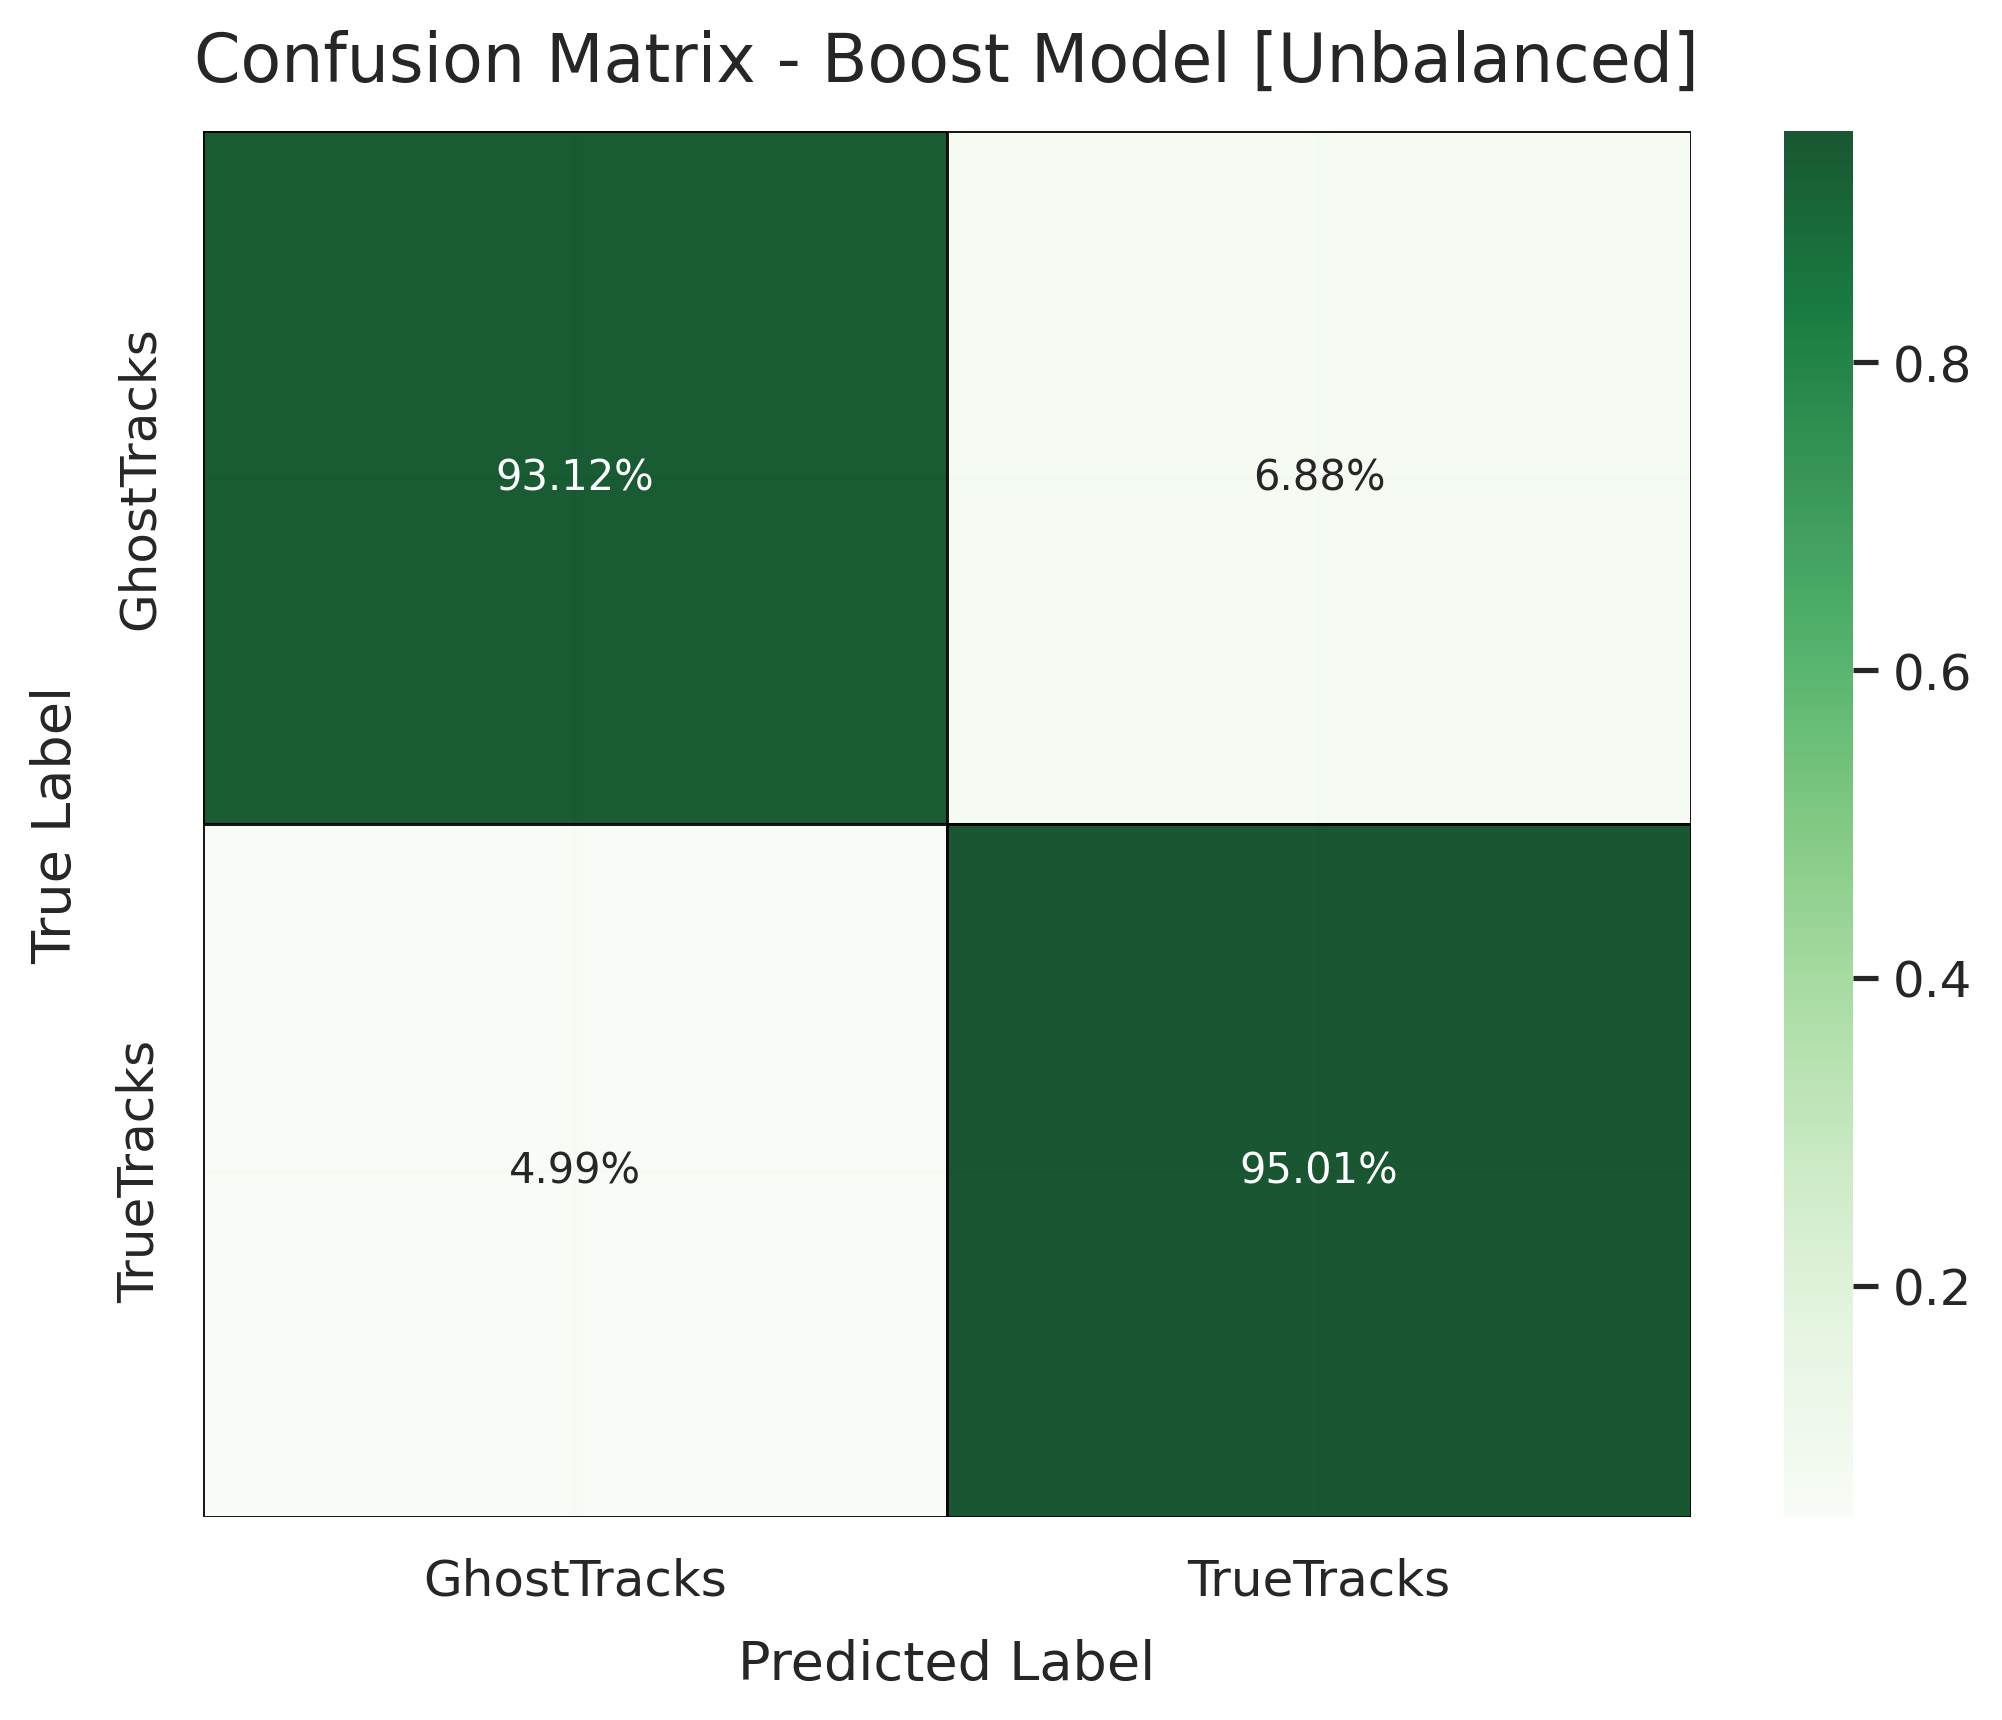

In [7]:
# Model Evaluation Test (Unbalanced Data) 
y_predict=model.predict(x_test)
print(f'ROC-AUC Score : ',round(roc_auc_score(y_test,y_predict)*100,2),'%')
print(f'F1 Score : ',round(f1_score(y_test,y_predict)*100,2),'%')

# ConfusionMatrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_predict,normalize='true'), xticklabels=['GhostTracks', 'TrueTracks'],yticklabels=['GhostTracks', 'TrueTracks'], fmt='.2%',annot=True, annot_kws={'fontsize': 10}, 
            cmap='Greens',linewidths=0.7,linecolor='black',alpha=0.9)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Boost Model [Unbalanced]')
plt.savefig(f"{figure_directory}/SciFi_Catboost_CM_Unbalanced.png")
plt.show()

ROC-AUC Score :  93.75 %
F1 Score :  97.27 %


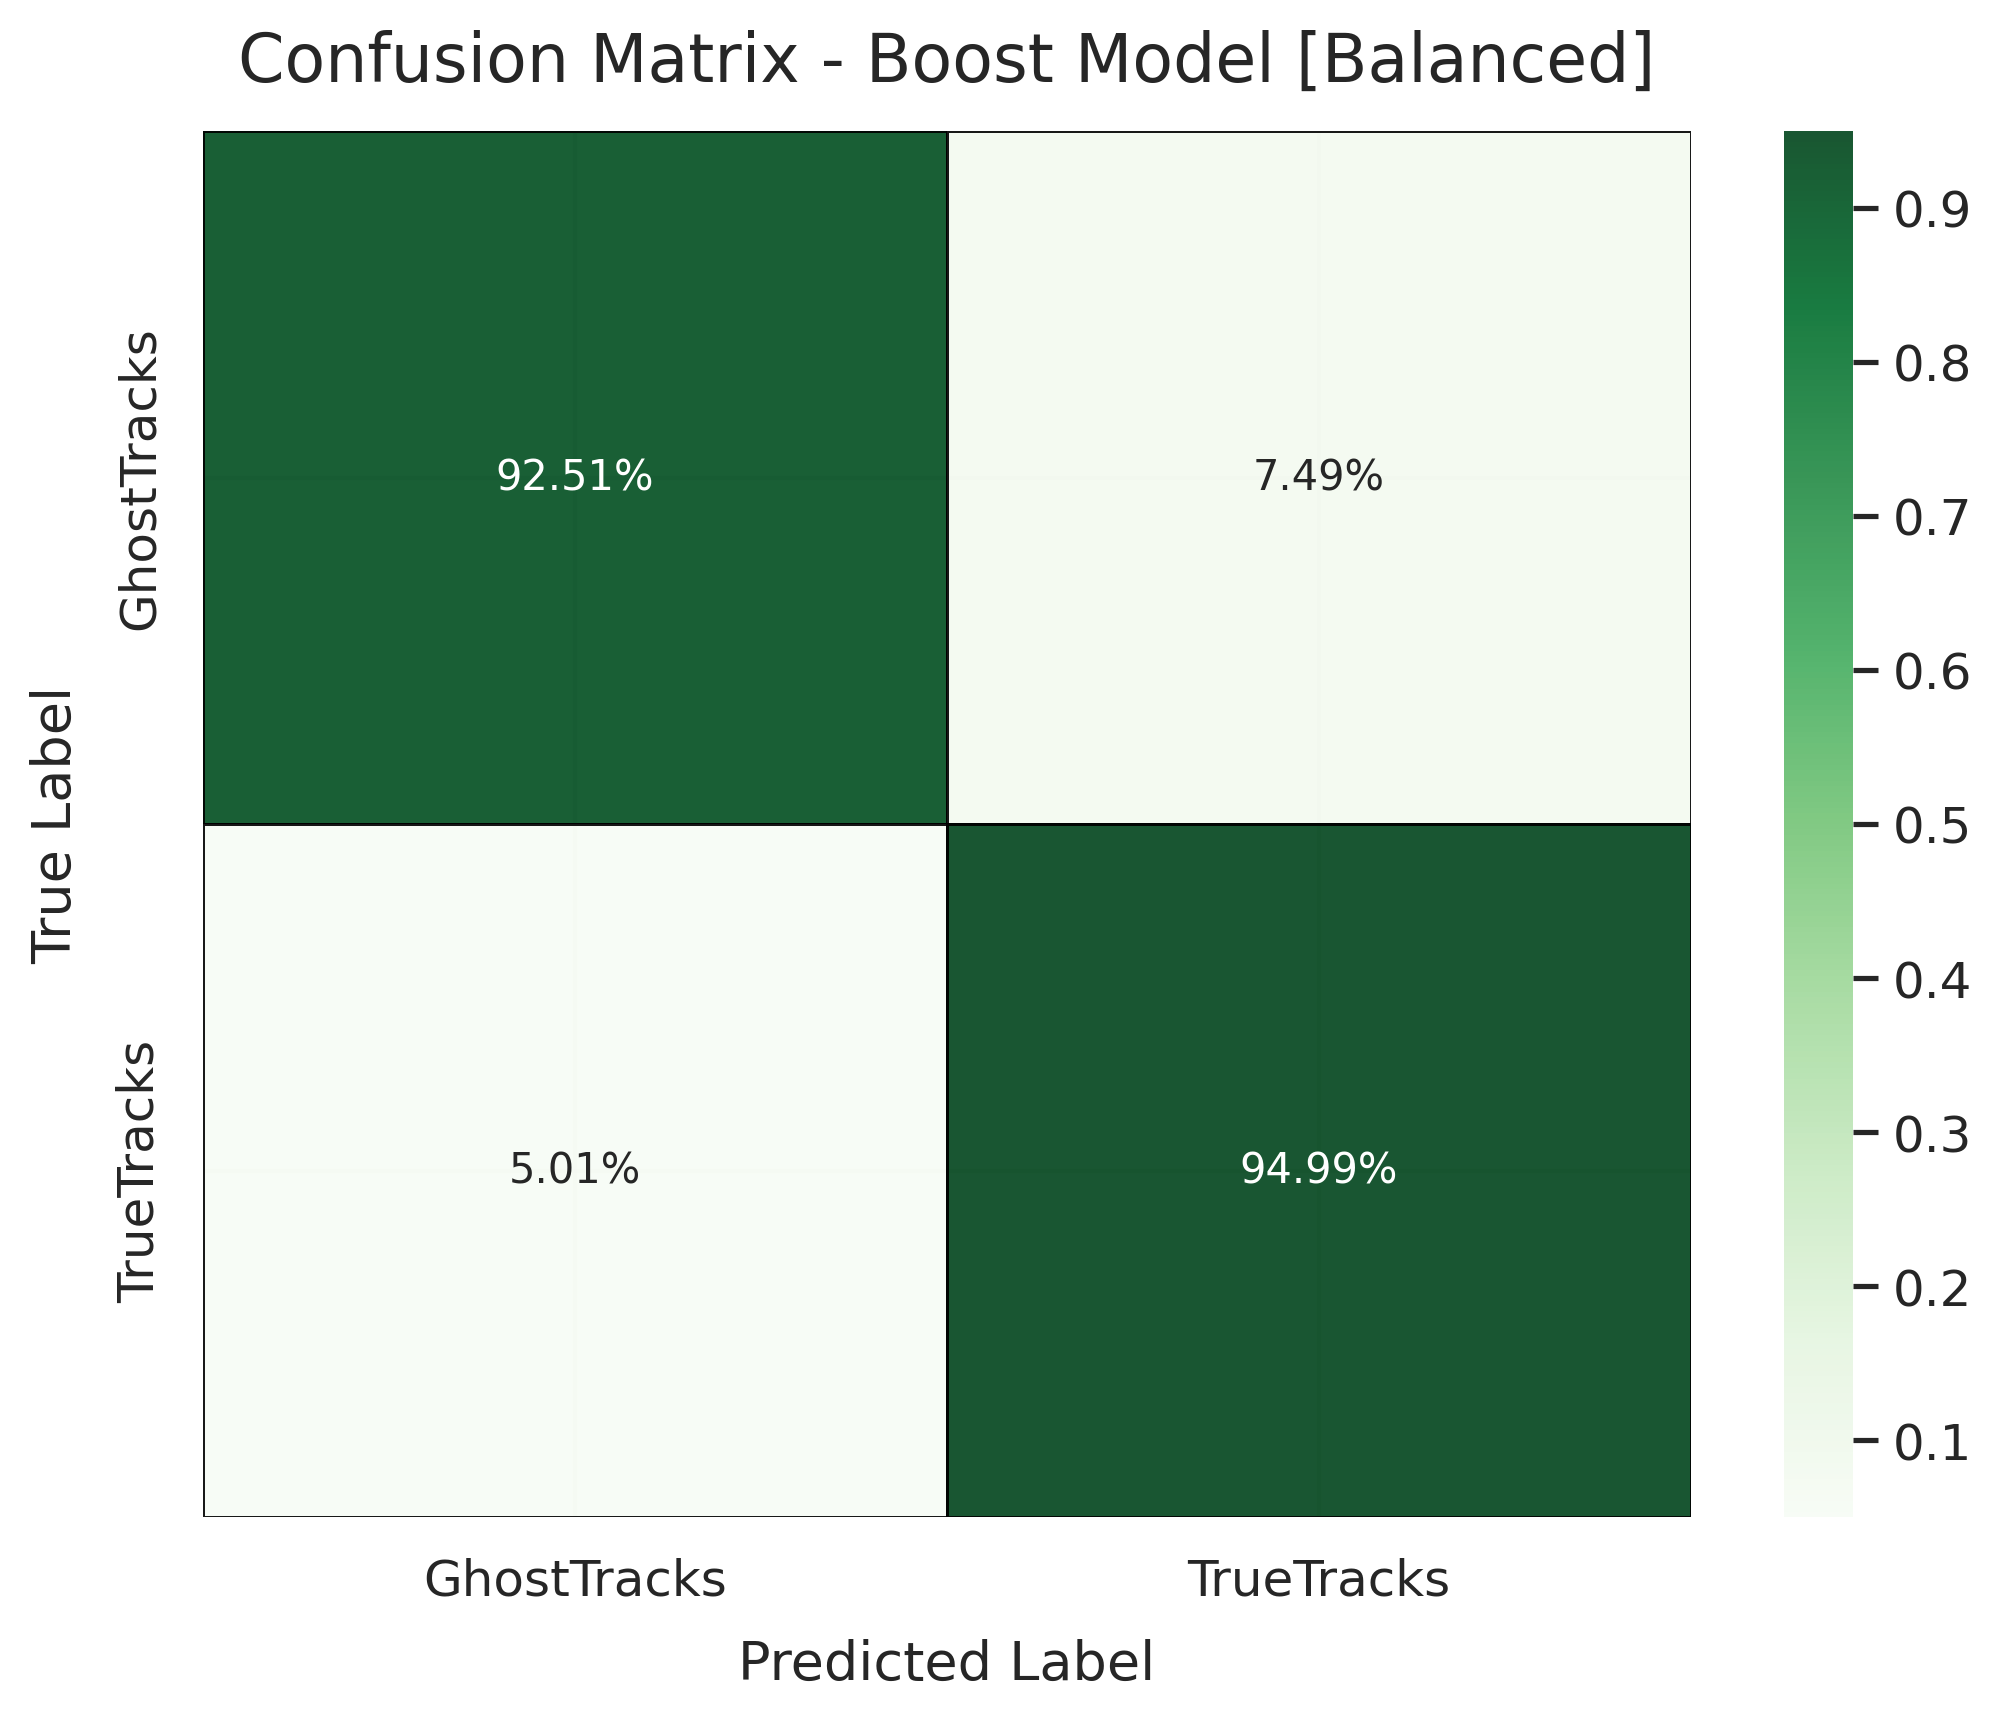

In [8]:
# Model Evaluation Eval (Balanced Data)
y_predict=model.predict(x_eval)
print(f'ROC-AUC Score : ',round(roc_auc_score(y_eval,y_predict)*100,2),'%')
print(f'F1 Score : ',round(f1_score(y_eval,y_predict)*100,2),'%')

# ConfusionMatrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_eval, y_predict,normalize='true'), xticklabels=['GhostTracks', 'TrueTracks'],yticklabels=['GhostTracks', 'TrueTracks'], fmt='.2%',annot=True, annot_kws={'fontsize': 10}, 
            cmap='Greens',linewidths=0.7,linecolor='black',alpha=0.9)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Boost Model [Balanced]')
plt.savefig(f"{figure_directory}/SciFi_Catboost_CM_Balanced.png")
plt.show()


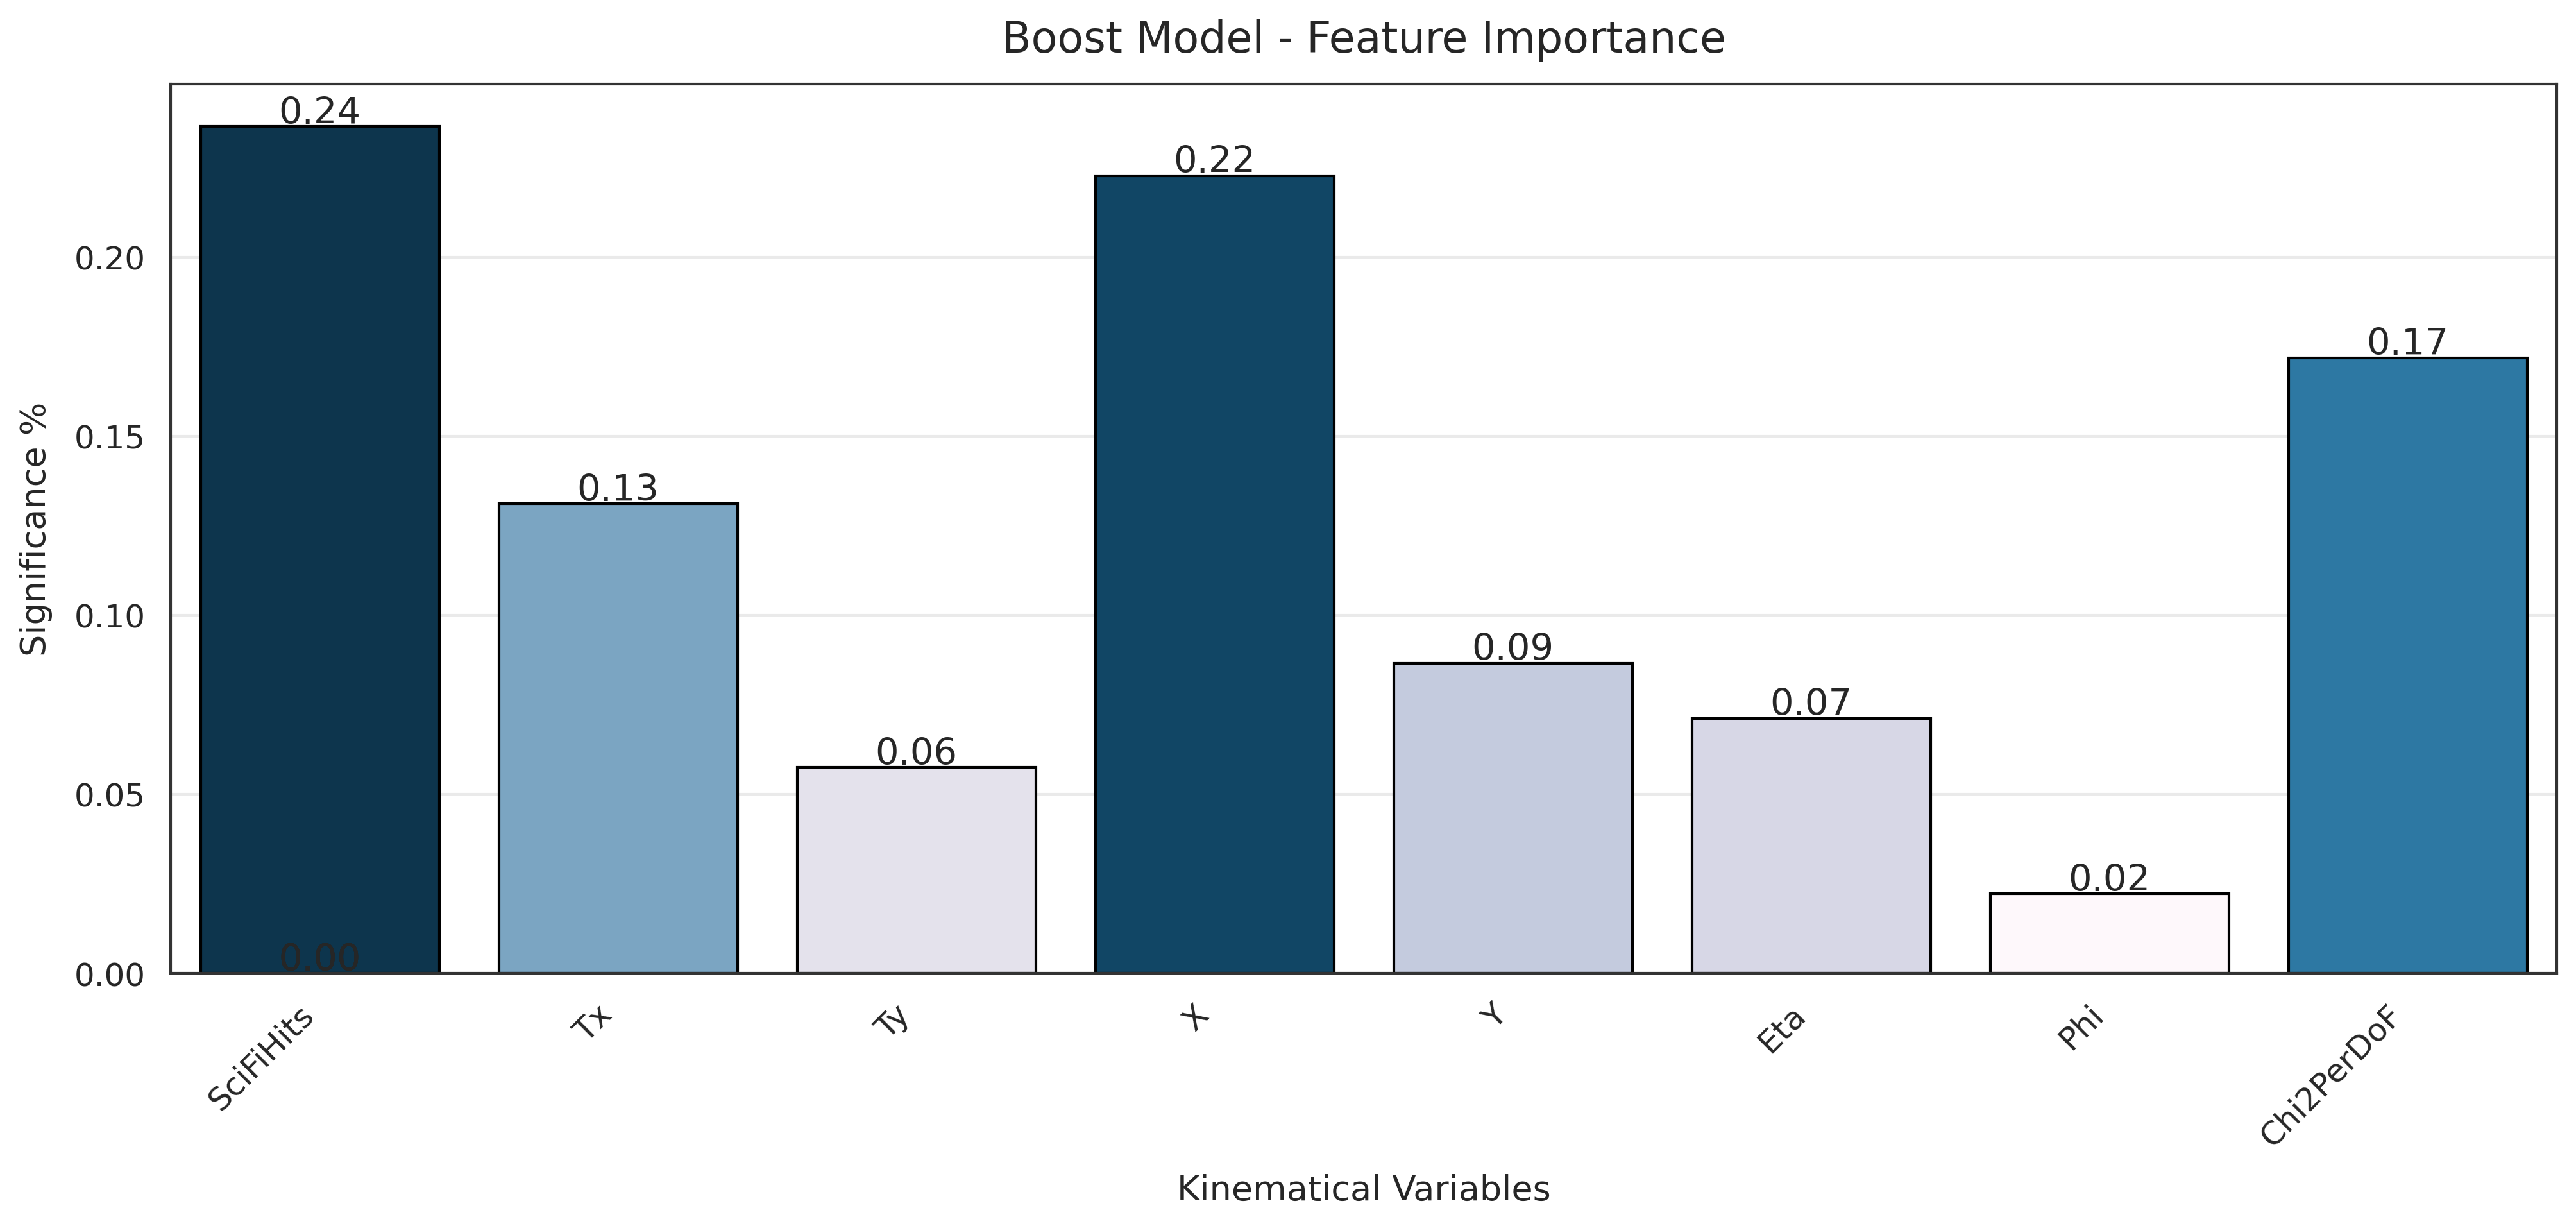

In [9]:
# FeatureImportance
plt.figure(figsize=(16, 6))
featureImportance = model.feature_importances_ / np.sum(model.feature_importances_)

ax=sns.barplot(x=columns, y=featureImportance,hue=model.feature_importances_,edgecolor='black',palette='PuBu')
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 5), 
                textcoords = 'offset points')
plt.title('Boost Model - Feature Importance')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Kinematical Variables')
plt.ylabel('Significance %')
ax.legend_.remove()
plt.savefig(f"{figure_directory}/SciFi_Catboost_FI.png")
plt.show()


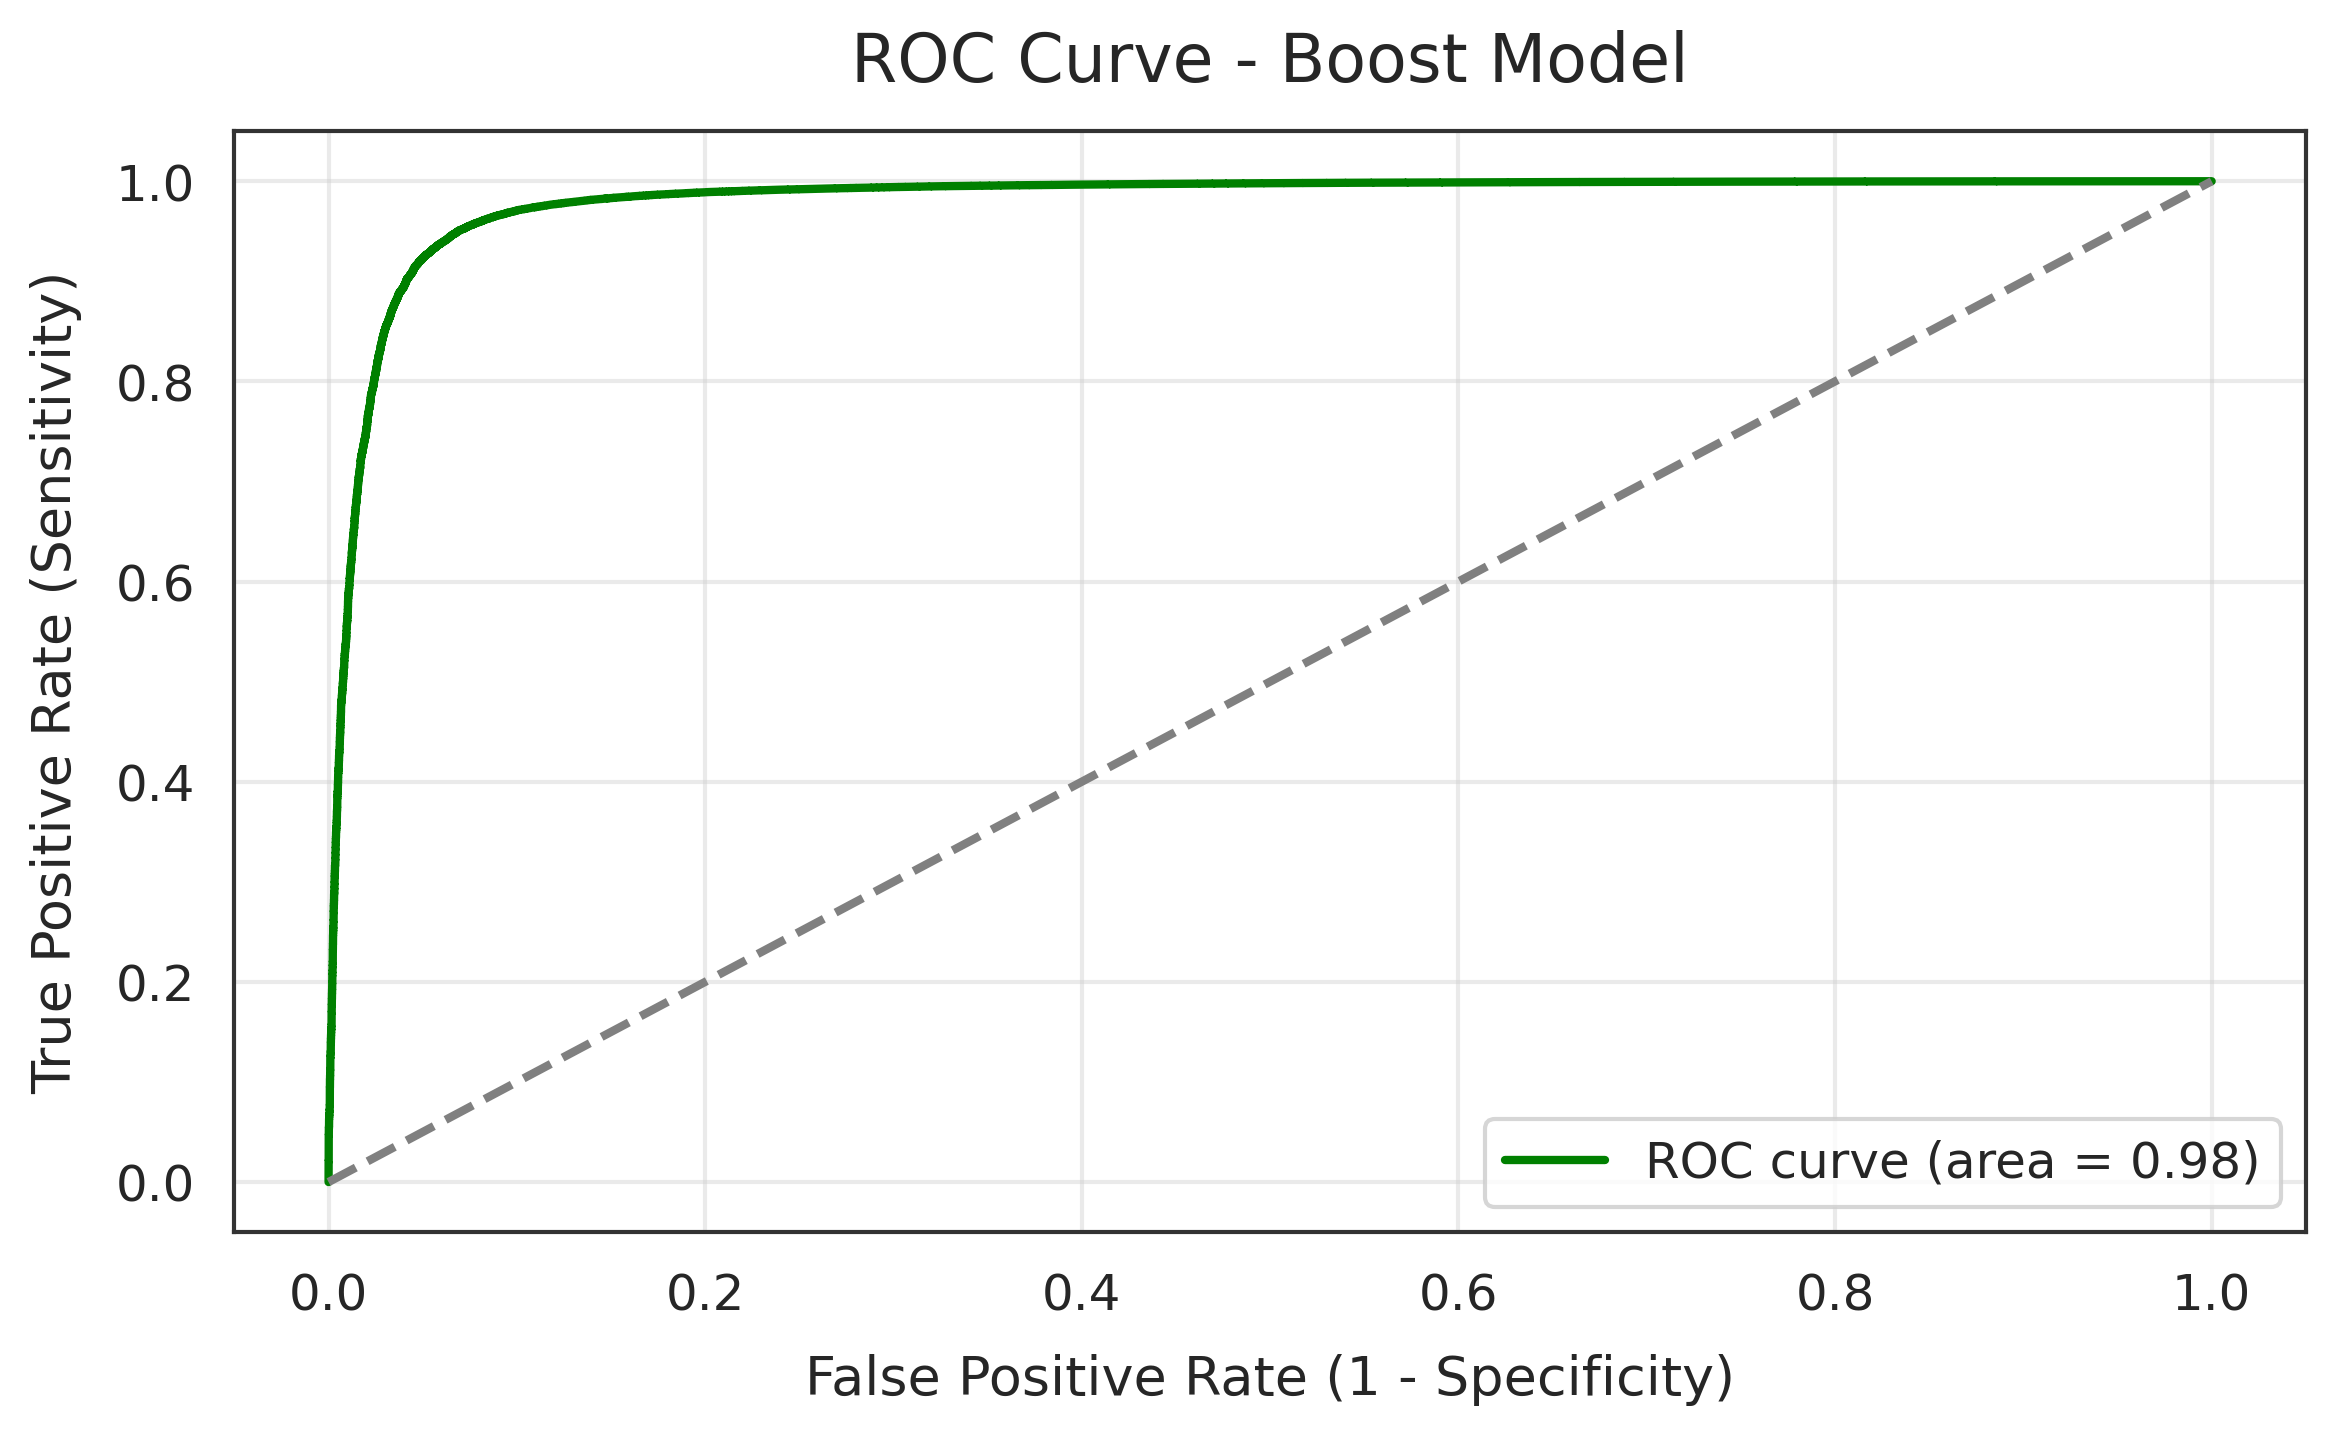

In [10]:
from sklearn.metrics import roc_curve,auc

evaluation=x_test.copy()

probabilityValue = model.predict_proba(evaluation)[:,1] #First Probability will make the plot upside down
fpr, tpr, threshold =roc_curve(y_test,  probabilityValue)

plt.figure(figsize=(8, 5))
plt.title('ROC Curve - Boost Model')
plt.plot(fpr, tpr,color='Green',label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.savefig(f"{figure_directory}/SciFi_Catboost_ROC.png")
plt.show()



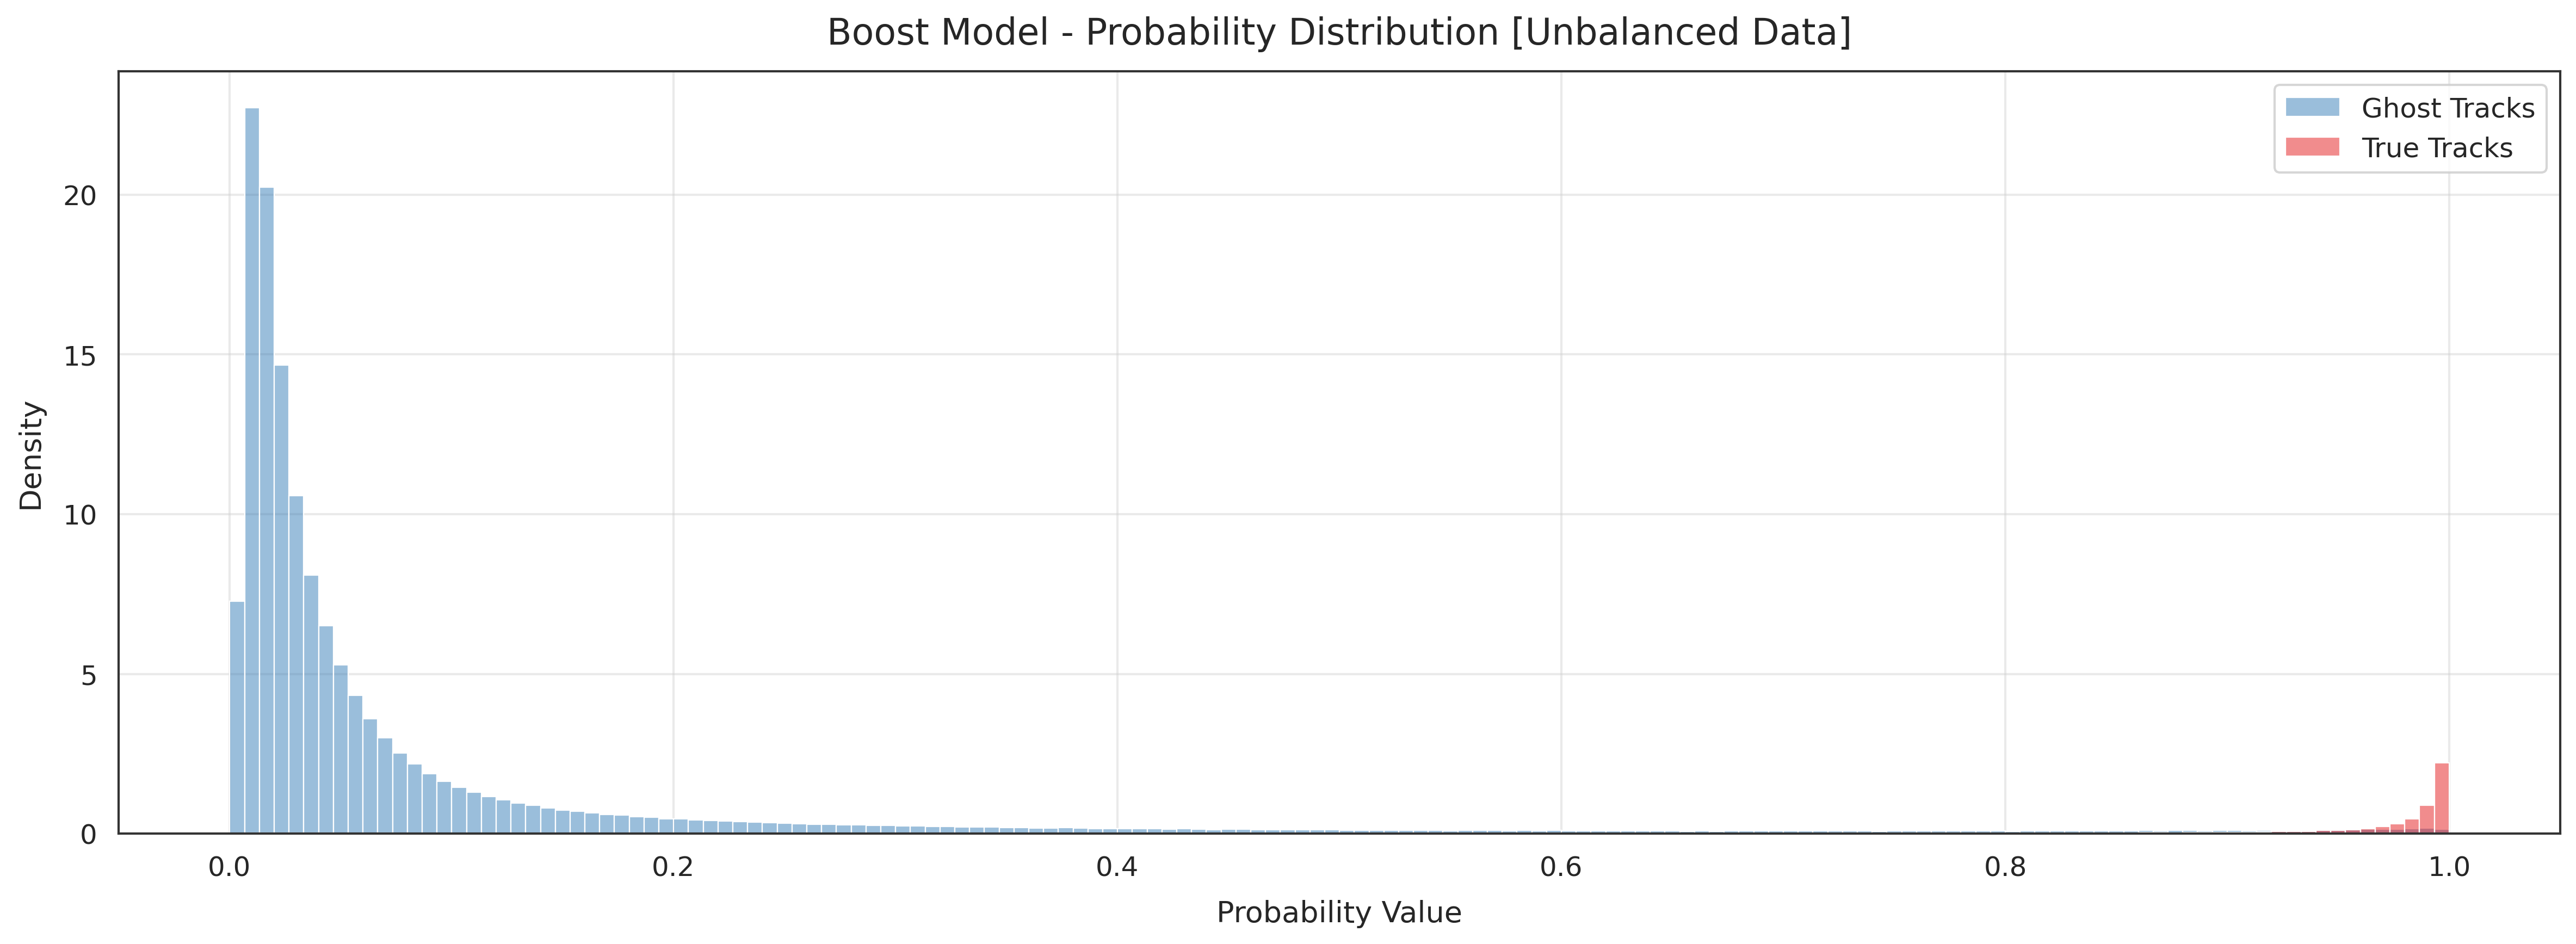

In [11]:
evaluation=x_test.copy()

probabilityValue = model.predict_proba(evaluation)[:,0] #Keeping the first set of probability for the distribution analysis
evaluation['ProbabilityValues']=probabilityValue
evaluation['TrueLabels']=y_test.values

plt.figure(figsize=(16, 6))
plt.title('Boost Model - Probability Distribution [Unbalanced Data]')
sns.histplot( x=evaluation['ProbabilityValues'], hue=evaluation['TrueLabels'], stat='density', bins=150, palette='Set1')
plt.xlabel('Probability Value')
plt.legend(labels=['Ghost Tracks', 'True Tracks'])
plt.savefig(f"{figure_directory}/SciFi_Catboost_ProbDist_Unbalanced.png")
plt.tight_layout()
plt.show()

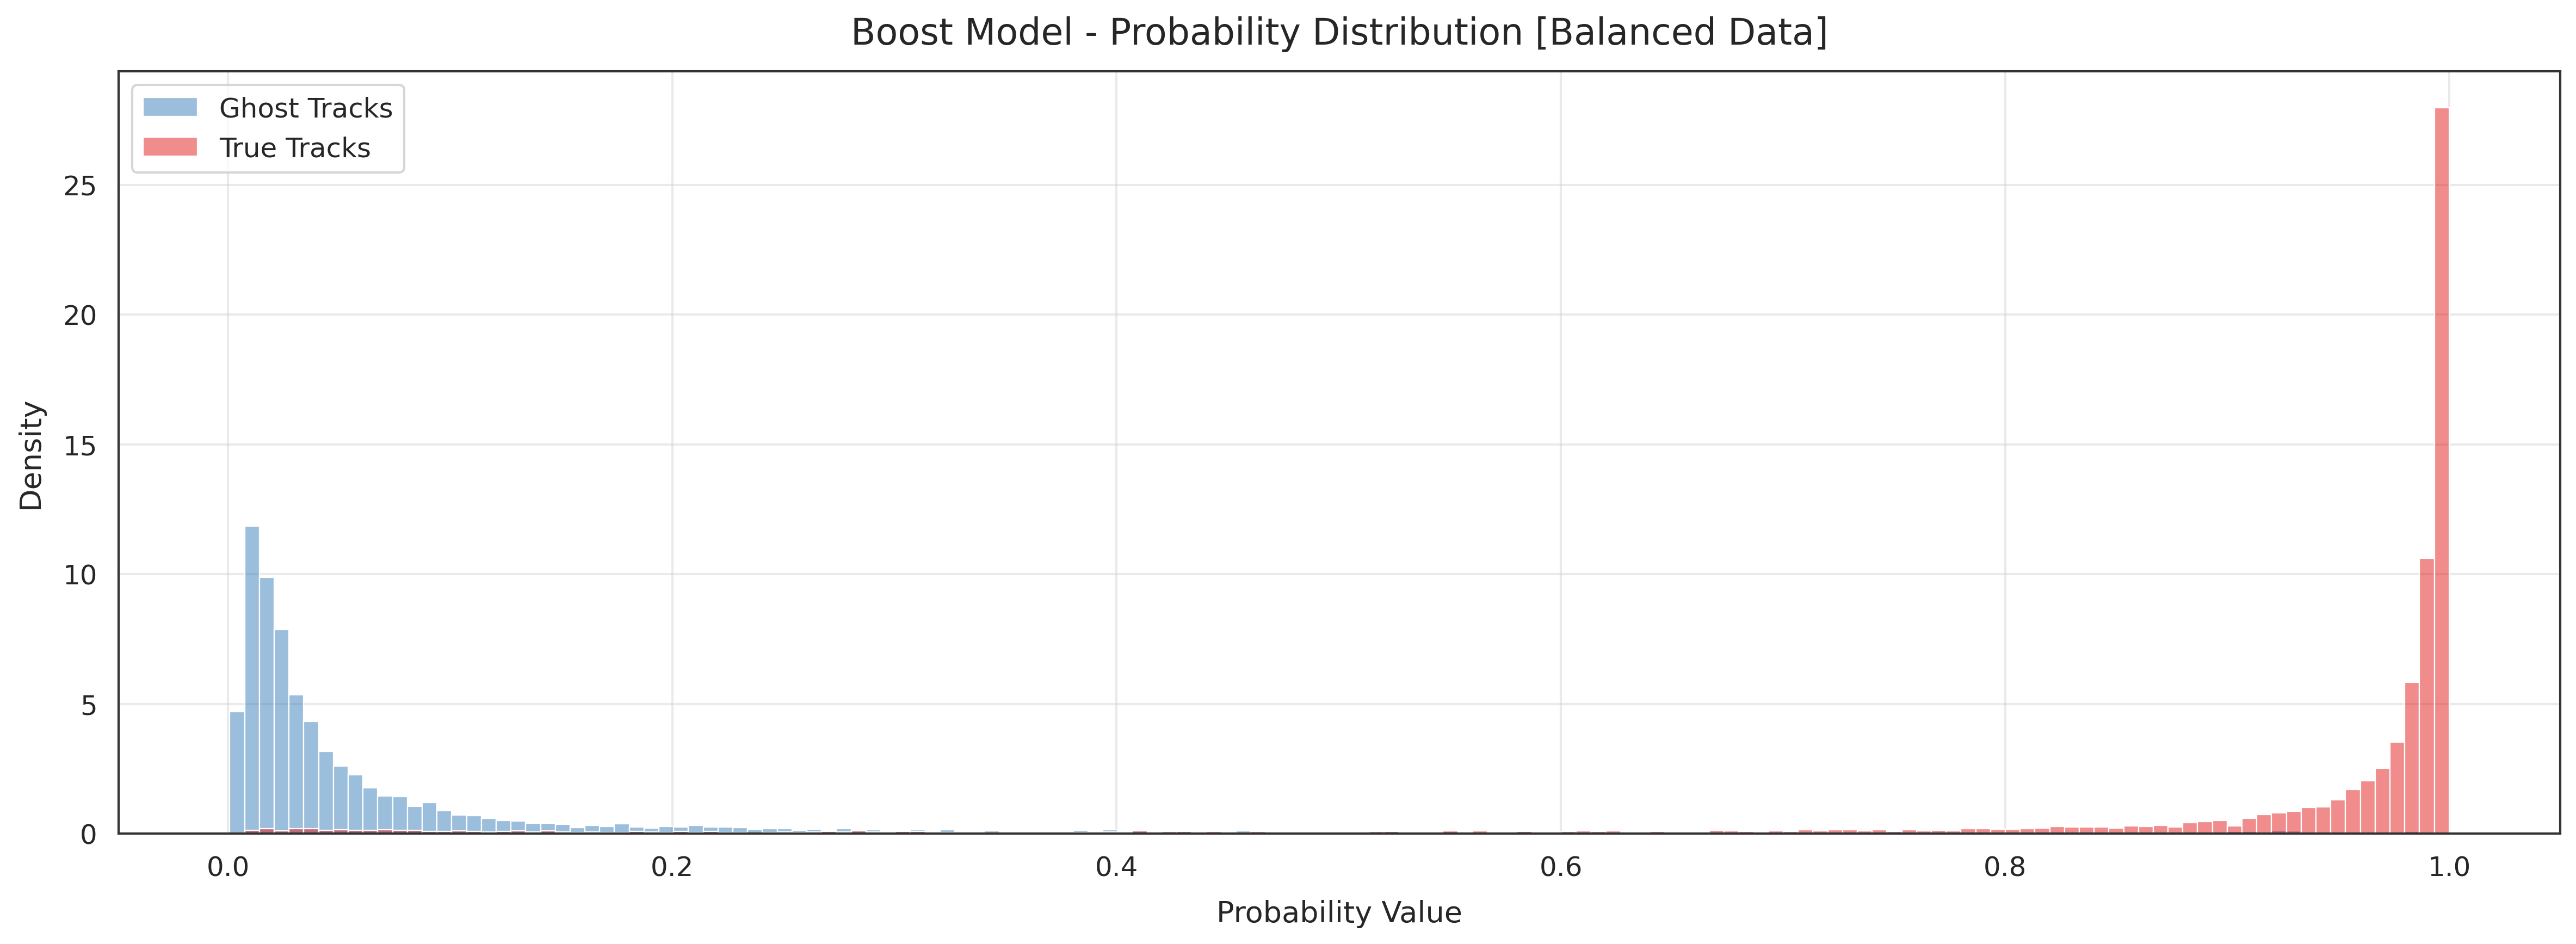

In [12]:
#Unlike previous notebooks, eval upsampling only here, for visualisation; no effects on training.
x_eval_balanced, y_eval_balanced = sampler.fit_resample(x_eval, y_eval)

evaluation=x_eval_balanced.copy()

probabilityValue = model.predict_proba(evaluation)[:,0] #Keeping the first set of probability for the distribution analysis
evaluation['ProbabilityValues']=probabilityValue
evaluation['TrueLabels']=y_eval_balanced.values

plt.figure(figsize=(16, 6))
plt.title('Boost Model - Probability Distribution [Balanced Data]')
sns.histplot( x=evaluation['ProbabilityValues'], hue=evaluation['TrueLabels'], stat='density', bins=150, palette='Set1')
plt.xlabel('Probability Value')
plt.legend(labels=['Ghost Tracks', 'True Tracks'])
plt.savefig(f"{figure_directory}/SciFi_Catboost_ProbDist_Balanced.png")

plt.tight_layout()
plt.show()

In [13]:
scaler.data_min_

array([ 9.00000000e+00, -1.06425428e+00, -3.90152931e-01, -2.64307129e+03,
       -2.08921777e+03,  8.01983887e-01, -3.14159238e+00,  1.51493319e-03])

In [14]:
scaler.data_max_

array([1.20000000e+01, 1.09440386e+00, 4.07895654e-01, 2.64208813e+03,
       2.07825049e+03, 1.06509545e+01, 3.14159247e+00, 4.99832964e+00])

In [15]:
#CPP Standalone
model.save_model('../../../../Models/StandaloneSciFiModel.cpp',format='cpp',pool=train_data)


#JSON
model.save_model('../../../../Models/JsonSciFiModel.json',format='json',pool=train_data)

In [16]:
import json

feature_mins = list(scaler.data_min_)
feature_maxs = list(scaler.data_max_)

with open("../../../../Models/JsonSciFiModel.json", "r") as f:
    model_json = json.load(f)

model_json["feature_mins"] = feature_mins
model_json["feature_maxs"] = feature_maxs


with open("../../../../Models/JsonSciFiModel_withScaling.json", "w") as f:
    json.dump(model_json, f, indent=2)

print("JSON Model saved with Scaling Factors")


JSON Model saved with Scaling Factors


In [17]:
#Evaluation
input_data = np.zeros(8)

input_data_df = pd.DataFrame(input_data.reshape(1, -1), columns=columns)  # Use the correct column names
input_data_scaled = scaler.transform(input_data_df)  # Transform the data using the scaler

probability = model.predict_proba(input_data_scaled)  # Get the probabilities
print("Probability of GhostTrack: ", probability[0][0])
print("Probability of TrueTrack: ", probability[0][1])


Probability of GhostTrack:  0.9880361689411368
Probability of TrueTrack:  0.011963831058863271


In [18]:
#End of Note